
# Econometrics

## Asymmetric Responses

### 根据原始情绪标签进行拟合

预处理聚合表格（1年数据）

In [3]:
import os
import pandas as pd

# 获取目录路径
script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
data_dir = os.path.join(script_dir, 'finbert_nas_scored.csv')
price_dir = os.path.join(script_dir, 'price_1y.csv')

# 1. 读取价格数据
price = pd.read_csv(price_dir, usecols=['Date', 'Stock_symbol', 'close', 'volume'])


# 2. 读取情绪数据
sentiment = pd.read_csv(data_dir, usecols=['Date', 'Stock_symbol', 'Sentiment'])
# 筛选2023年的数据
sentiment['Date'] = pd.to_datetime(sentiment['Date'])
sentiment = sentiment[sentiment['Date'].dt.year == 2023]
print(f"筛选后2023年的数据量: {len(sentiment)}")



# 3. 转换日期格式（确保两边一致）
price['Date'] = pd.to_datetime(price['Date']).dt.tz_localize(None)
sentiment['Date'] = pd.to_datetime(sentiment['Date']).dt.tz_localize(None)

# 将情绪数据的日期向后调整一天
sentiment['Date'] = sentiment['Date'] + pd.Timedelta(days=1)

# 4. 计算平均情绪（按股票和日期分组）
sentiment_mean = sentiment.groupby(['Stock_symbol', 'Date'])['Sentiment'].mean().reset_index()

# 5. 合并数据
merged_data = pd.merge(
    price,
    sentiment_mean,
    on=['Date', 'Stock_symbol'],
    how='left'  # 保留price中的所有行
)

# # 6. 设置面板数据格式（MultiIndex）
# merged_data = merged_data.set_index(['Stock_symbol', 'Date']).sort_index()

# # 7. 转换为PeriodIndex（如果需要）
# merged_data.index = merged_data.index.set_levels(
#     merged_data.index.levels[1].to_period('D'),  # 对第二层索引（Date）转换
#     level='Date'
# )

print(merged_data.head())



筛选后2023年的数据量: 150096
        Date      volume       close Stock_symbol  Sentiment
0 2023-01-03  23175300.0   35.570000        CMCSA        NaN
1 2023-01-03   2948500.0   90.680000          DHI        NaN
2 2023-01-03   2098400.0   95.760002           ED        NaN
3 2023-01-03   1266800.0   84.220001           ES        NaN
4 2023-01-03   1181600.0  185.149994         ADSK        NaN


新加了一个可视化：计算T期的sentiment与T+1,...T+60期的close的相关系数

c:\Users\Mencius\anaconda3\envs\fnspid\lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Mencius\anaconda3\envs\fnspid\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Mencius\anaconda3\envs\fnspid\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\Mencius\anaconda3\envs\fnspid\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Mencius\anaconda3\envs\fnspid\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Mencius\anaconda3\envs\fnspid\lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c 

Average correlation coefficients for all stocks:
Correlation between sentiment on day T and close price on day T+1: 0.0701
Correlation between sentiment on day T and close price on day T+2: 0.0825
Correlation between sentiment on day T and close price on day T+3: 0.0647
Correlation between sentiment on day T and close price on day T+4: 0.0722
Correlation between sentiment on day T and close price on day T+5: 0.0728
Correlation between sentiment on day T and close price on day T+6: 0.0822
Correlation between sentiment on day T and close price on day T+7: 0.0707
Correlation between sentiment on day T and close price on day T+8: 0.0732
Correlation between sentiment on day T and close price on day T+9: 0.0501
Correlation between sentiment on day T and close price on day T+10: 0.0572
Correlation between sentiment on day T and close price on day T+11: 0.0476
Correlation between sentiment on day T and close price on day T+12: 0.0578
Correlation between sentiment on day T and close price on da

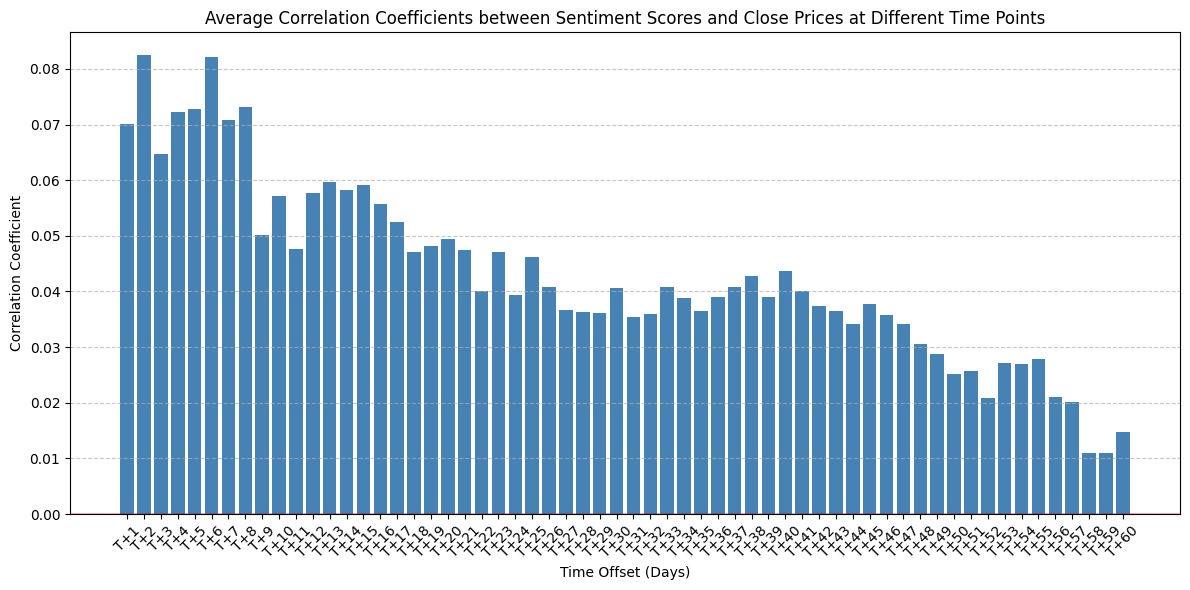

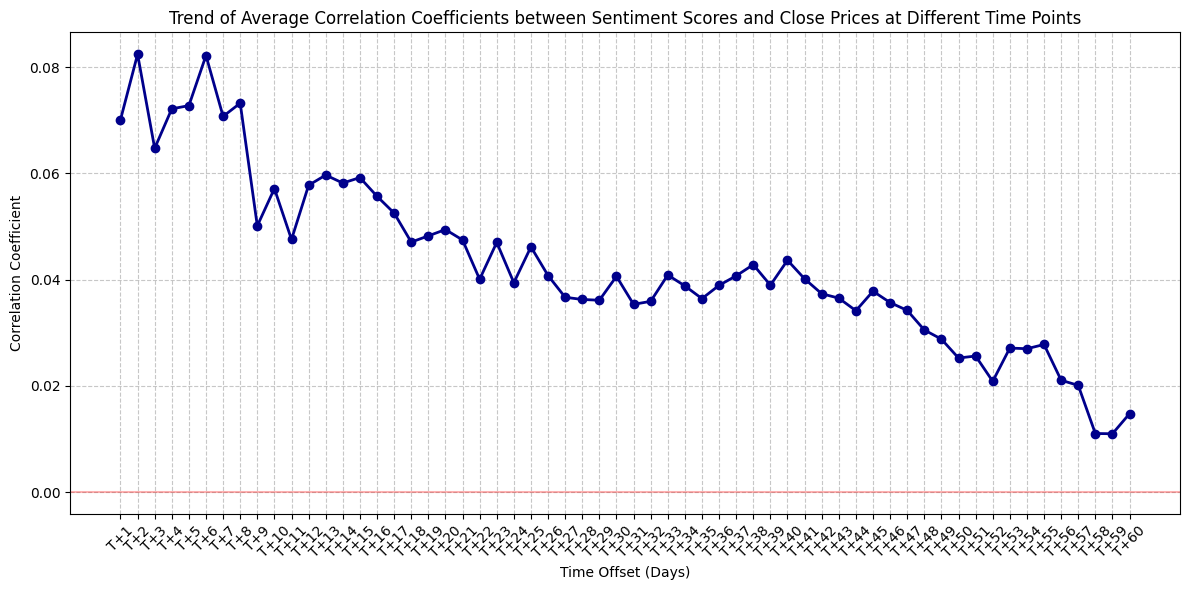

In [3]:
# Calculate correlation between sentiment and close prices at different time points

# Ensure data is sorted by date and stock symbol
merged_data = merged_data.sort_values(['Stock_symbol', 'Date'])

# Create an empty dictionary to store all correlation coefficients
all_correlations = []

# Calculate correlation coefficients for each stock
for symbol, group in merged_data.groupby('Stock_symbol'):
    # Create time-shifted close prices for the current stock
    group['close_T'] = group['close']  # Today's close price
    
    # Create shifted columns from T+1 to T+60
    for i in range(1, 61):
        group[f'close_T_plus_{i}'] = group['close'].shift(-i)
    
    # Calculate correlation coefficients for the current stock
    symbol_correlations = {}
    symbol_correlations['Stock_symbol'] = symbol
    symbol_correlations['T'] = group['Sentiment'].corr(group['close_T'])
    
    # Calculate correlations from T+1 to T+30
    for i in range(1, 61):
        symbol_correlations[f'T+{i}'] = group['Sentiment'].corr(group[f'close_T_plus_{i}'])
    
    all_correlations.append(symbol_correlations)

# Convert all correlation coefficients to DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

corr_df = pd.DataFrame(all_correlations)

# Calculate average correlation coefficients for all stocks
avg_correlations = {}
# avg_correlations['T'] = corr_df['T'].mean()
for i in range(1, 61):
    avg_correlations[f'T+{i}'] = corr_df[f'T+{i}'].mean()

# Print average correlation coefficients
print("Average correlation coefficients for all stocks:")
for key, value in avg_correlations.items():
    print(f"Correlation between sentiment on day T and close price on day {key}: {value:.4f}")

# Create visualization - only show averages
plt.figure(figsize=(12, 6))

# Prepare data
time_points = ['T'] + [f'T+{i}' for i in range(1, 61)]
time_points = [f'T+{i}' for i in range(1, 61)]
avg_values = [avg_correlations[t] for t in time_points]

# Plot bar chart
plt.bar(range(len(time_points)), avg_values, color='steelblue')

# Add chart elements
plt.title('Average Correlation Coefficients between Sentiment Scores and Close Prices at Different Time Points')
plt.xlabel('Time Offset (Days)')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(len(time_points)), time_points, rotation=45)
plt.tight_layout()
plt.show()

# A line chart version can also be added for clearer trend visualization
plt.figure(figsize=(12, 6))
plt.plot(range(len(time_points)), avg_values, 'o-', linewidth=2, color='darkblue')
plt.title('Trend of Average Correlation Coefficients between Sentiment Scores and Close Prices at Different Time Points')
plt.xlabel('Time Offset (Days)')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(range(len(time_points)), time_points, rotation=45)
plt.tight_layout()
plt.show()

用哑变量进行拟合

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels import PanelOLS, RandomEffects
from linearmodels.iv import IVGMM
from scipy import stats

df = merged_data
# ======================
# 数据预处理
# ======================
# 1. 计算日收益率
df['return'] = df.groupby('Stock_symbol')['close'].pct_change()


# 2. 创建情绪虚拟变量
df['positive'] = (df['Sentiment'] >= 0).astype(int)
df['negative'] = (df['Sentiment'] < 0).astype(int)

# 3. 创建滞后项（用于扩展分析）
df['lag_return_1'] = df.groupby('Stock_symbol')['return'].shift(1)
df['lag_return_2'] = df.groupby('Stock_symbol')['return'].shift(2)
#print(df.head())

# 重置索引并确保日期格式

df['Date'] = pd.to_datetime(df['Date'])  # 确保是datetime格式
df = df.set_index(['Stock_symbol', 'Date']).sort_index()

# 然后继续预处理和回归
# ======================
# 基准模型：不包含历史股价
# ======================
print("\n=== 基准模型（同期效应） ===")
model_baseline = PanelOLS.from_formula(
    'return ~ 1 + positive + negative',
    data=df.dropna(subset=['positive', 'negative'])
)
results_baseline = model_baseline.fit(cov_type='clustered', cluster_entity=True)
print(results_baseline)


=== 基准模型（同期效应） ===
                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.0013
Estimator:                   PanelOLS   R-squared (Between):              0.0071
No. Observations:               84320   R-squared (Within):               0.0013
Date:                Tue, May 13 2025   R-squared (Overall):              0.0013
Time:                        22:40:01   Log-likelihood                 2.197e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      55.561
Entities:                         340   P-value                           0.0000
Avg Obs:                       248.00   Distribution:                 F(2,84317)
Min Obs:                       248.00                                           
Max Obs:                       248.00   F-statistic (robust):             45.192
        

c:\Users\Mencius\anaconda3\envs\fnspid\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


加入滞后项再拟合

In [5]:

# ======================
# 扩展分析1：加入滞后项
# ======================
print("\n=== 扩展分析1：加入滞后项 ===")
model_lag1 = PanelOLS.from_formula(
    'return ~ 1 + positive + negative + lag_return_1',
    data=df.dropna(subset=['positive', 'negative', 'lag_return_1'])
)
results_lag1 = model_lag1.fit(cov_type='clustered', cluster_entity=True)
print(results_lag1)

# 比较系数变化
coef_diff = pd.DataFrame({
    'Baseline': results_baseline.params[['positive', 'negative']],
    'With_Lag': results_lag1.params[['positive', 'negative']],
    'Diff': results_lag1.params[['positive', 'negative']] - results_baseline.params[['positive', 'negative']]
})
print("\n情绪系数变化对比：")
print(coef_diff)

from statsmodels.stats.outliers_influence import variance_inflation_factor
exog = sm.add_constant(df[['positive','negative','lag_return_1']].dropna())
pd.Series([variance_inflation_factor(exog.values, i) for i in range(exog.shape[1])], 
          index=exog.columns)


=== 扩展分析1：加入滞后项 ===
                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.0013
Estimator:                   PanelOLS   R-squared (Between):              0.0294
No. Observations:               83980   R-squared (Within):               0.0012
Date:                Tue, May 13 2025   R-squared (Overall):              0.0013
Time:                        22:40:14   Log-likelihood                 2.189e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      36.323
Entities:                         340   P-value                           0.0000
Avg Obs:                       247.00   Distribution:                 F(3,83976)
Min Obs:                       247.00                                           
Max Obs:                       247.00   F-statistic (robust):             29.113
       

const           1.699286
positive        1.033319
negative        1.033519
lag_return_1    1.000232
dtype: float64

加入波动率交叉项

In [4]:
# 创建虚拟变量（中性新闻为基准组）
df['is_positive'] = (df['Sentiment'] == 1).astype(int)
df['is_negative'] = (df['Sentiment'] == -1).astype(int)

# 假设已计算收益率波动率
df['volatility'] = df.groupby('Stock_symbol')['return'].transform(lambda x: x.rolling(5).std())

model_interaction = PanelOLS.from_formula(
    'return ~ 1 + is_positive*volatility + is_negative*volatility + lag_return_1',
    data=df.dropna()
)

results_interaction = model_interaction.fit(cov_type='clustered', cluster_entity=True)
print(results_interaction)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.0022
Estimator:                   PanelOLS   R-squared (Between):              0.0099
No. Observations:                 948   R-squared (Within):               0.0021
Date:                Mon, May 12 2025   R-squared (Overall):              0.0022
Time:                        18:21:32   Log-likelihood                    2683.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.3530
Entities:                           5   P-value                           0.9083
Avg Obs:                       189.60   Distribution:                   F(6,941)
Min Obs:                       124.00                                           
Max Obs:                       236.00   F-statistic (robust):          1.925e+13
                            

交互相应三维图

Text(0.5, 0, 'Return')

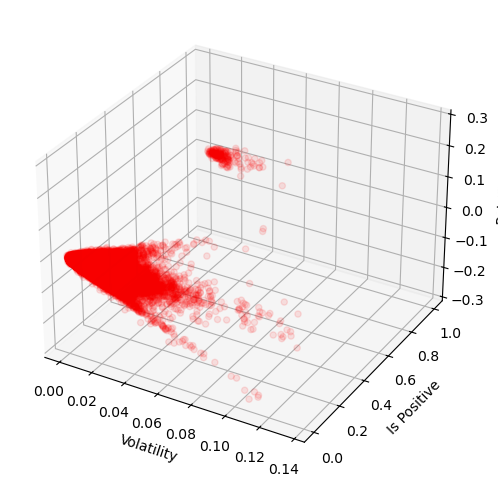

In [6]:
# 交互效应三维图
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['volatility'], df['is_positive'], df['return'], c='r', alpha=0.1)
ax.set_xlabel('Volatility')
ax.set_ylabel('Is Positive')
ax.set_zlabel('Return')

用原始变量直接拟合

In [7]:
import pandas as pd
import numpy as np
from linearmodels import PanelOLS

# 数据预处理
df = merged_data.copy()

# 1. 计算日收益率
df['return'] = df.groupby('Stock_symbol')['close'].pct_change()

# 2. 使用原始Sentiment变量（不再创建虚拟变量）
# 原始Sentiment已经是-1,0,1三分类变量

# 3. 创建滞后项
df['lag_return_1'] = df.groupby('Stock_symbol')['return'].shift(1)
df['lag_return_2'] = df.groupby('Stock_symbol')['return'].shift(2)


# 4. 设置面板数据格式
df['Date'] = pd.to_datetime(df['Date'])  # 确保日期格式
df = df.set_index(['Stock_symbol', 'Date']).sort_index()

# 5. 基准模型：使用连续型Sentiment
print("\n=== 使用连续型Sentiment的基准模型 ===")
model_continuous = PanelOLS.from_formula(
    'return ~ 1 + Sentiment',  # 直接使用Sentiment变量
    data=df.dropna(subset=['Sentiment', 'return'])
)
results_continuous = model_continuous.fit(cov_type='clustered', cluster_entity=True)
print(results_continuous)

# 6. 扩展模型：加入交互项（示例）
df['volatility'] = df.groupby('Stock_symbol')['return'].transform(lambda x: x.rolling(5).std())

print("\n=== 带波动率交互项的模型 ===")
model_interaction = PanelOLS.from_formula(
    'return ~ 1 + Sentiment*volatility + lag_return_1',
    data=df.dropna(subset=['Sentiment', 'return', 'volatility'])
)
results_interaction = model_interaction.fit(cov_type='clustered', cluster_entity=True)
print(results_interaction)


=== 使用连续型Sentiment的基准模型 ===
                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.0008
Estimator:                   PanelOLS   R-squared (Between):             -0.0061
No. Observations:                 953   R-squared (Within):               0.0009
Date:                Mon, May 12 2025   R-squared (Overall):              0.0008
Time:                        18:24:18   Log-likelihood                    2696.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.7589
Entities:                           5   P-value                           0.3839
Avg Obs:                       190.60   Distribution:                   F(1,951)
Min Obs:                       125.00                                           
Max Obs:                       237.00   F-statistic (robust):             0.9287

### 将情绪识别的条件严格化

把超过n条的才算做有情绪

In [8]:
import os
import pandas as pd

# 获取目录路径
script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
data_dir = os.path.join(script_dir, 'finbert_nas_scored.csv')
price_dir = os.path.join(script_dir, 'price_1y.csv')

# 1. 读取价格数据
price = pd.read_csv(price_dir, usecols=['Date', 'Stock_symbol', 'close','volume'])

# 2. 读取情绪数据
sentiment = pd.read_csv(data_dir, usecols=['Date', 'Stock_symbol', 'Sentiment'])
# 筛选2023年的数据
sentiment['Date'] = pd.to_datetime(sentiment['Date'])
sentiment = sentiment[sentiment['Date'].dt.year == 2023]
print(f"筛选后2023年的数据量: {len(sentiment)}")

# 3. 转换日期格式
price['Date'] = pd.to_datetime(price['Date']).dt.tz_localize(None)
sentiment['Date'] = pd.to_datetime(sentiment['Date']).dt.tz_localize(None)

# 将情绪数据的日期向后调整一天
sentiment['Date'] = sentiment['Date'] + pd.Timedelta(days=1)


# 4. 创建新的情绪指标
def calculate_new_sentiment(group):
    # 计算1和-1的出现次数
    count_pos = (group['Sentiment'] > 0 ).sum()
    count_neg = (group['Sentiment'] < 0).sum()

    min_count = 2
    # 根据条件确定new_sentiment值
    if count_neg >= min_count:
        return -1
    elif count_pos >= min_count:
        return 1
    else:
        return 0

# 按日期和股票代码分组计算new_sentiment
new_sentiment = sentiment.groupby(['Date', 'Stock_symbol']).apply(calculate_new_sentiment).reset_index()
new_sentiment.columns = ['Date', 'Stock_symbol', 'new_sentiment']

# 5. 合并数据
merged_data = pd.merge(
    price,
    new_sentiment,
    on=['Date', 'Stock_symbol'],
    how='left'  # 保留price中的所有行
)

# 6. 填充缺失的new_sentiment为0（如果没有情绪数据）
merged_data['new_sentiment'] = merged_data['new_sentiment'].fillna(0)

# 7. 输出结果
print(merged_data.head())

# 可选：保存结果到文件
merged_data.to_csv('merged_data_with_new_sentiment.csv', index=False)

筛选后2023年的数据量: 150096


C:\Users\Mencius\AppData\Local\Temp\ipykernel_20024\3379959254.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_sentiment = sentiment.groupby(['Date', 'Stock_symbol']).apply(calculate_new_sentiment).reset_index()


        Date      volume       close Stock_symbol  new_sentiment
0 2023-01-03  23175300.0   35.570000        CMCSA            0.0
1 2023-01-03   2948500.0   90.680000          DHI            0.0
2 2023-01-03   2098400.0   95.760002           ED            0.0
3 2023-01-03   1266800.0   84.220001           ES            0.0
4 2023-01-03   1181600.0  185.149994         ADSK            0.0


In [11]:
data_1y_augment = merged_data
# 修改列名：将 'volume' 改为 'Volume'，将 'close' 改为 'Close'
if 'volume' in data_1y_augment.columns:
    data_1y_augment = data_1y_augment.rename(columns={'volume': 'Volume'})
if 'close' in data_1y_augment.columns:
    data_1y_augment = data_1y_augment.rename(columns={'close': 'Close'})

# 打印修改后的列名，确认更改成功
print("修改后的列名:", data_1y_augment.columns.tolist())


out_dir = os.path.join(script_dir, 'data_1y_augment')
os.makedirs(out_dir, exist_ok=True)
newscount = []
# 按照 Stock_symbol 分组并保存为独立的CSV文件
for stock_symbol, group_df in data_1y_augment.groupby('Stock_symbol'):
    if pd.notna(stock_symbol) and str(stock_symbol).strip() != "":
        newscount.append(stock_symbol)
        filename = f"{stock_symbol}.csv"
        output_path = os.path.join(out_dir, filename)
        group_df.to_csv(output_path, index=False)

print(len(newscount))

修改后的列名: ['Date', 'Volume', 'Close', 'Stock_symbol', 'new_sentiment']
340


In [32]:
sentiment['Stock_symbol'].nunique()

350

In [35]:
# 检查一天中一个股票代码有超过1条新闻的情况

# 首先计算每天每个股票的新闻数量
daily_news_count = sentiment.groupby(['Date', 'Stock_symbol']).size().reset_index(name='news_count')

# 找出新闻数量大于1的记录
multiple_news = daily_news_count[daily_news_count['news_count'] > 1]

# 统计结果
total_days_with_multiple_news = len(multiple_news)
max_news_in_one_day = multiple_news['news_count'].max()
avg_news_when_multiple = multiple_news['news_count'].mean()

# 输出结果
print(f"一天中一个股票有多条新闻的情况共有 {total_days_with_multiple_news} 条记录")
print(f"一天中一个股票最多有 {max_news_in_one_day} 条新闻")
print(f"当有多条新闻时，平均每天每个股票的新闻数量为 {avg_news_when_multiple:.2f} 条")

# 查看前几条多新闻的记录示例
print("\n多新闻记录示例:")
print(multiple_news.sort_values('news_count', ascending=False).head(10))

# 统计不同新闻数量的分布
news_count_distribution = multiple_news['news_count'].value_counts().sort_index()
print("\n新闻数量分布:")
print(news_count_distribution)


# 计算有多少个不同的股票存在一天内有多条新闻的情况
stocks_with_multiple_news = multiple_news['Stock_symbol'].nunique()
total_stocks = sentiment['Stock_symbol'].nunique()

print(f"\n共有 {stocks_with_multiple_news} 个不同的股票在某一天内有多条新闻")
print(f"占总股票数量 ({total_stocks} 个) 的 {stocks_with_multiple_news/total_stocks*100:.2f}%")

# 查看每个股票有多少天出现多条新闻的情况
stock_multiple_news_days = multiple_news.groupby('Stock_symbol').size().reset_index(name='days_with_multiple_news')
stock_multiple_news_days = stock_multiple_news_days.sort_values('days_with_multiple_news', ascending=False)

print("\n出现多条新闻天数最多的前10只股票:")
print(stock_multiple_news_days.head(10))

# 统计每只股票出现多条新闻的天数分布
days_distribution = stock_multiple_news_days['days_with_multiple_news'].value_counts().sort_index()
print("\n股票出现多条新闻的天数分布:")
print(days_distribution)





一天中一个股票有多条新闻的情况共有 27634 条记录
一天中一个股票最多有 99 条新闻
当有多条新闻时，平均每天每个股票的新闻数量为 4.58 条

多新闻记录示例:
            Date Stock_symbol  news_count
19909 2023-05-25         NVDA          99
33724 2023-08-24         NVDA          93
15362 2023-04-26         MSFT          80
41921 2023-10-19         TSLA          64
33541 2023-08-23         NVDA          64
20517 2023-05-30         NVDA          61
14460 2023-04-20         TSLA          61
28180 2023-07-20         TSLA          59
33363 2023-08-22         NVDA          59
46948 2023-11-21         NVDA          58

新闻数量分布:
news_count
2     11076
3      5893
4      3251
5      1992
6      1274
      ...  
61        2
64        2
80        1
93        1
99        1
Name: count, Length: 63, dtype: int64

共有 349 个不同的股票在某一天内有多条新闻
占总股票数量 (350 个) 的 99.71%

出现多条新闻天数最多的前10只股票:
    Stock_symbol  days_with_multiple_news
1           AAPL                      338
313         TSLA                      335
224         MSFT                      335
243         NVDA         

In [25]:
# 检查有多少个不同的股票代码
unique_stocks = merged_data['Stock_symbol'].nunique()
print(f"数据集中共有 {unique_stocks} 个不同的股票代码")



数据集中共有 340 个不同的股票代码


In [33]:
# 检验条数
print(merged_data[merged_data['new_sentiment']==-1])


            Date       close Stock_symbol  new_sentiment
1409  2023-01-09  108.470001          XOM           -1.0
1419  2023-01-09  130.149994         AAPL           -1.0
1430  2023-01-09   88.800003         GOOG           -1.0
1448  2023-01-09  156.350006          TGT           -1.0
1464  2023-01-09   44.700001          BAX           -1.0
...          ...         ...          ...            ...
81757 2023-12-15   65.220001          GIS           -1.0
81758 2023-12-15  380.510010           GS           -1.0
81768 2023-12-15   35.730000           GM           -1.0
81804 2023-12-15  149.279999          LEN           -1.0
81886 2023-12-15   14.320000          KEY           -1.0

[3632 rows x 4 columns]


c:\Users\Mencius\anaconda3\envs\fnspid\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Mencius\anaconda3\envs\fnspid\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Mencius\anaconda3\envs\fnspid\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Mencius\anaconda3\envs\fnspid\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Mencius\anaconda3\envs\fnspid\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Mencius\anaconda3\envs\fnspid\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\M

Average correlation coefficients for all stocks:
Correlation between sentiment on day T and close price on day T+1: 0.0526
Correlation between sentiment on day T and close price on day T+2: 0.0527
Correlation between sentiment on day T and close price on day T+3: 0.0516
Correlation between sentiment on day T and close price on day T+4: 0.0507
Correlation between sentiment on day T and close price on day T+5: 0.0486
Correlation between sentiment on day T and close price on day T+6: 0.0470
Correlation between sentiment on day T and close price on day T+7: 0.0472
Correlation between sentiment on day T and close price on day T+8: 0.0479
Correlation between sentiment on day T and close price on day T+9: 0.0459
Correlation between sentiment on day T and close price on day T+10: 0.0448
Correlation between sentiment on day T and close price on day T+11: 0.0445
Correlation between sentiment on day T and close price on day T+12: 0.0425
Correlation between sentiment on day T and close price on da

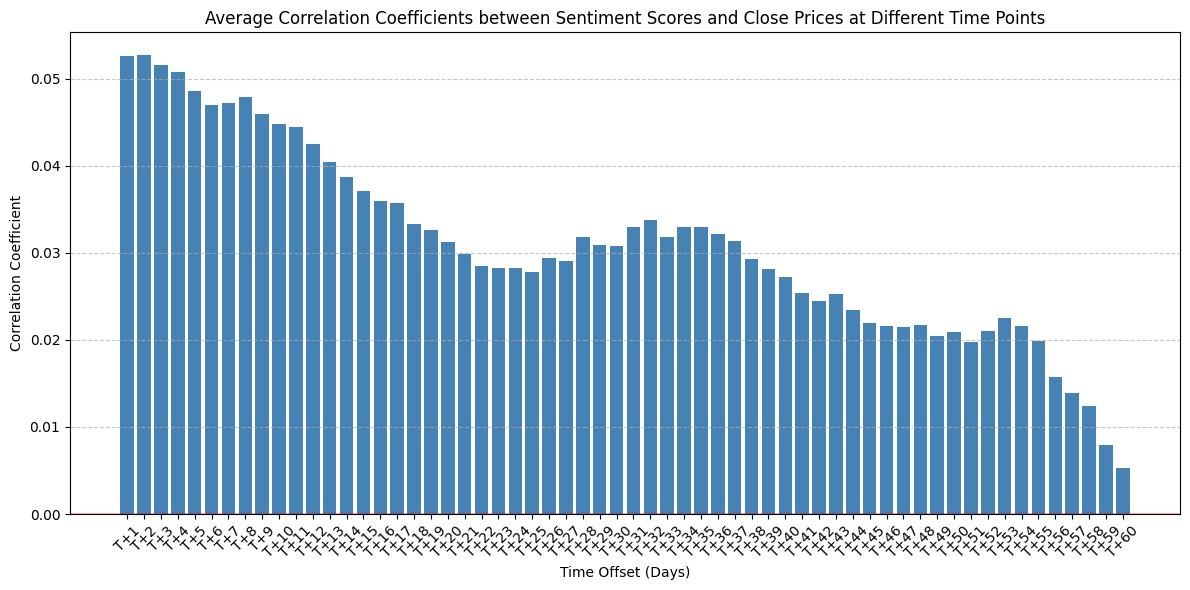

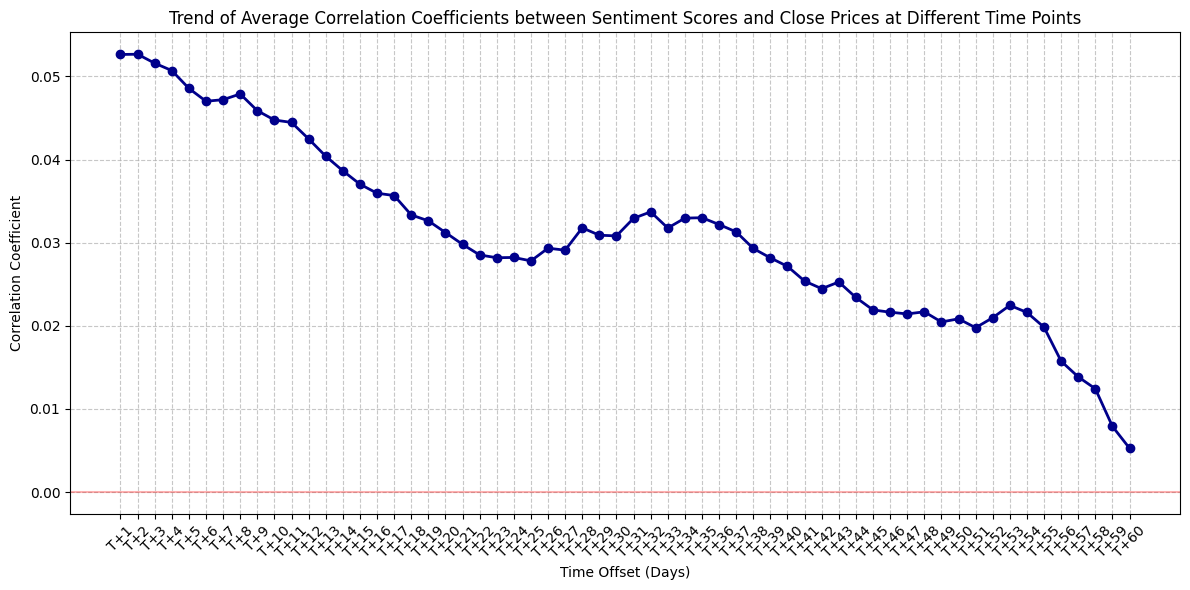

In [36]:
# Calculate correlation between new_sentiment and close prices at different time points

# Ensure data is sorted by date and stock symbol
merged_data = merged_data.sort_values(['Stock_symbol', 'Date'])

# Create an empty dictionary to store all correlation coefficients
all_correlations = []

# Calculate correlation coefficients for each stock
for symbol, group in merged_data.groupby('Stock_symbol'):
    # Create time-shifted close prices for the current stock
    group['close_T'] = group['close']  # Today's close price
    
    # Create shifted columns from T+1 to T+60
    for i in range(1, 61):
        group[f'close_T_plus_{i}'] = group['close'].shift(-i)
    
    # Calculate correlation coefficients for the current stock
    symbol_correlations = {}
    symbol_correlations['Stock_symbol'] = symbol
    symbol_correlations['T'] = group['new_sentiment'].corr(group['close_T'])
    
    # Calculate correlations from T+1 to T+30
    for i in range(1, 61):
        symbol_correlations[f'T+{i}'] = group['new_sentiment'].corr(group[f'close_T_plus_{i}'])
    
    all_correlations.append(symbol_correlations)

# Convert all correlation coefficients to DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

corr_df = pd.DataFrame(all_correlations)

# Calculate average correlation coefficients for all stocks
avg_correlations = {}
# avg_correlations['T'] = corr_df['T'].mean()
for i in range(1, 61):
    avg_correlations[f'T+{i}'] = corr_df[f'T+{i}'].mean()

# Print average correlation coefficients
print("Average correlation coefficients for all stocks:")
for key, value in avg_correlations.items():
    print(f"Correlation between sentiment on day T and close price on day {key}: {value:.4f}")

# Create visualization - only show averages
plt.figure(figsize=(12, 6))

# Prepare data
time_points = ['T'] + [f'T+{i}' for i in range(1, 61)]
time_points = [f'T+{i}' for i in range(1, 61)]
avg_values = [avg_correlations[t] for t in time_points]

# Plot bar chart
plt.bar(range(len(time_points)), avg_values, color='steelblue')

# Add chart elements
plt.title('Average Correlation Coefficients between Sentiment Scores and Close Prices at Different Time Points')
plt.xlabel('Time Offset (Days)')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(len(time_points)), time_points, rotation=45)
plt.tight_layout()
plt.show()

# A line chart version can also be added for clearer trend visualization
plt.figure(figsize=(12, 6))
plt.plot(range(len(time_points)), avg_values, 'o-', linewidth=2, color='darkblue')
plt.title('Trend of Average Correlation Coefficients between Sentiment Scores and Close Prices at Different Time Points')
plt.xlabel('Time Offset (Days)')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(range(len(time_points)), time_points, rotation=45)
plt.tight_layout()
plt.show()

In [40]:
df.columns

Index(['close', 'new_sentiment', 'return', 'positive', 'negative',
       'lag_return_1', 'lag_return_2'],
      dtype='object')

用哑变量拟合

In [41]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels import PanelOLS, RandomEffects
from linearmodels.iv import IVGMM
from scipy import stats

df = merged_data
# ======================
# 数据预处理
# ======================
# 1. 计算日收益率
df['return'] = df.groupby('Stock_symbol')['close'].pct_change()


# 2. 创建情绪虚拟变量
df['positive'] = (df['new_sentiment'] > 0).astype(int)
df['negative'] = (df['new_sentiment'] < 0).astype(int)

# 3. 创建滞后项（用于扩展分析）
df['lag_return_1'] = df.groupby('Stock_symbol')['return'].shift(1)
df['lag_return_2'] = df.groupby('Stock_symbol')['return'].shift(2)
#print(df.head())

# 重置索引并确保日期格式

df['Date'] = pd.to_datetime(df['Date'])  # 确保是datetime格式
df = df.set_index(['Stock_symbol', 'Date']).sort_index()

# 然后继续预处理和回归
# ======================
# 基准模型：不包含历史股价
# ======================
print("\n=== 基准模型（同期效应） ===")
model_baseline = PanelOLS.from_formula(
    'return ~ 1 + positive + negative + lag_return_1 + lag_return_2',
    data=df.dropna(subset=['positive', 'negative'])
)
results_baseline = model_baseline.fit(cov_type='clustered', cluster_entity=True)
print(results_baseline)


=== 基准模型（同期效应） ===
                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.0030
Estimator:                   PanelOLS   R-squared (Between):             -0.1923
No. Observations:               83640   R-squared (Within):               0.0037
Date:                Wed, May 14 2025   R-squared (Overall):              0.0030
Time:                        00:02:58   Log-likelihood                 2.182e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      63.669
Entities:                         340   P-value                           0.0000
Avg Obs:                       246.00   Distribution:                 F(4,83635)
Min Obs:                       246.00                                           
Max Obs:                       246.00   F-statistic (robust):             18.292
        

c:\Users\Mencius\anaconda3\envs\fnspid\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


用原始变量拟合

In [38]:
import pandas as pd
import numpy as np
from linearmodels import PanelOLS

# 数据预处理
df = merged_data.copy()

# 1. 计算日收益率
df['return'] = df.groupby('Stock_symbol')['close'].pct_change()

# 2. 使用原始Sentiment变量（不再创建虚拟变量）
# 原始Sentiment已经是-1,0,1三分类变量

# 3. 创建滞后项
df['lag_return_1'] = df.groupby('Stock_symbol')['return'].shift(1)
df['lag_return_2'] = df.groupby('Stock_symbol')['return'].shift(2)

# 4. 设置面板数据格式
df['Date'] = pd.to_datetime(df['Date'])  # 确保日期格式
df = df.set_index(['Stock_symbol', 'Date']).sort_index()

# 5. 基准模型：使用连续型Sentiment
print("\n=== 使用连续型Sentiment的基准模型 ===")
model_continuous = PanelOLS.from_formula(
    'return ~ 1 + new_sentiment',  # 直接使用Sentiment变量
    data=df.dropna(subset=['new_sentiment', 'return'])
)
results_continuous = model_continuous.fit(cov_type='clustered', cluster_entity=True)
print(results_continuous)

# 6. 扩展模型：加入交互项（示例）
df['volatility'] = df.groupby('Stock_symbol')['return'].transform(lambda x: x.rolling(5).std())

print("\n=== 带波动率交互项的模型 ===")
model_interaction = PanelOLS.from_formula(
    'return ~ 1 + new_sentiment*volatility + lag_return_1',
    data=df.dropna(subset=['new_sentiment', 'return', 'volatility'])
)
results_interaction = model_interaction.fit(cov_type='clustered', cluster_entity=True)
print(results_interaction)


=== 使用连续型Sentiment的基准模型 ===
                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.0024
Estimator:                   PanelOLS   R-squared (Between):             -0.0676
No. Observations:               84320   R-squared (Within):               0.0026
Date:                Tue, May 13 2025   R-squared (Overall):              0.0024
Time:                        23:49:57   Log-likelihood                 2.198e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      200.88
Entities:                         340   P-value                           0.0000
Avg Obs:                       248.00   Distribution:                 F(1,84318)
Min Obs:                       248.00                                           
Max Obs:                       248.00   F-statistic (robust):             63.485